# 神经网络实现鸢尾花分类
- 数据准备
    - 读取数据集
    - 数据集打乱顺序
    - 生成训练集和测试集
    - 配成（输入特征，标签）对，每次读入一部分
- 搭建网络
    - 定义神经网络中所有的可训练参数
- 参数优化
    - 嵌套循环迭代，with结构跟新参数，计算损失函数
- 测试效果
    - 测试集准确率，显示当前accuracy
- acc/loss曲线可视化

### 利用鸢尾花数据集，实现前向传播和反向传播，可视化loss曲线

In [67]:
# 导入所需模块
import tensorflow as tf
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

# 加载数据集 ,分别为输入特征和标签
x_data = datasets.load_iris().data
y_data = datasets.load_iris().target

print(f'x_data.shape:{x_data.shape}')
print(f'y_data.shape:{y_data.shape}')

x_data.shape:(150, 4)
y_data.shape:(150,)


In [68]:
# 随机打乱数据的顺序，确保随机性，不打乱会影响准确率
# seed: 随机种子数，是一个整数，当设置后，每次生成的随机数都一样，方便复现
np.random.seed(seed=116)
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

In [69]:
# 将打乱后的数据集分割为训练集和验证集 ，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

# 转化x的数据类型，确保矩阵相乘时不会因数据类型不同而报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

# 使用from_tensor_slices函数时输入特征和标签值一一对应。（把数据集分批次，每个批次为batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [70]:
# 生成神经网络的参数，4个输入特征吗，输入层为4个输入节点; 因为结果只有3个，所以输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 是用seed使每次生成的随机数相同，方便调试（实际开发不需要）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

print(f'w1 = {w1.numpy()}, w1.shape = {w1.shape}')
print(f'b1 = {b1.numpy()}, b1.shape = {b1.shape}')

w1 = [[ 0.08249953 -0.0683137   0.19668601]
 [-0.05480815  0.04570521  0.1357149 ]
 [ 0.07750896 -0.16734955 -0.10294553]
 [ 0.15784004 -0.13311003  0.06045313]], w1.shape = (4, 3)
b1 = [-0.09194934 -0.12376948 -0.05381497], b1.shape = (3,)


w1 的形状为 [4, 3]，因为：
1.	输入层有 4 个节点（输入特征数为 4）。
2.	输出层有 3 个节点（输出神经元数为 3）。
3.	权重矩阵的形状为 [输入节点数, 输出节点数]，以满足矩阵乘法规则。

b1 的形状为 [3]，因为每个输出神经元需要一个偏置，对应输出层的 3 个节点。

In [71]:
# 学习率
lr = 0.1 
# 将每轮的loss记录在此列表中，为后续画loss曲线做准备
train_loss_results = []
# 将每轮的acc记录在此列表中，为后续画acc曲线做准备
test_acc = []
# 训练次数
epoch = 500
# 每轮分为4个，loss_all记录四个step生成的4个loss的和
loss_all = 0

In [ ]:
# 训练部分
# 数据集级别的循环，每个eopch循环一次数据集
for epoch in range(epoch):
    # btach级别的循环，每个step循环一次batch
    for step, (x_train, y_train) in enumerate(train_db):
        # with 结构记录梯度信息
        with tf.GradientTape() as tape:
            # 神经网络乘加运算
            y = tf.matmul(x_train, w1) + b1
            # 使输出y符合概率分布（此操作后与独热码同量级，可相减计算loss）
            y = tf.nn.softmax(y)
            # 将标签值转为独热码格式，方便计算loss和accuracy
            y_ = tf.one_hot(y_train, depth=3)
            # 采用均方误差损失环视mse = mean(sum(y-out)^2)
            loss =tf.reduce_mean(tf.square(y_ - y))
            # 将每个step的loss累加起来，为后续求平均值做准备，这样计算的loss更准确
            loss_all += loss.numpy()
        # 计算loss对w1和b1的梯度
        grads = tape.gradient(loss, [w1, b1])
        
        # 实现梯度下降更新参数
        # w1 = w1 - lr * w1_grad b = b - lr * b_grad
        # 参数w1自更新
        w1.assign_sub(lr * grads[0])
        # 参数b1自更新
        b1.assign_sub(lr * grads[1])
        
    # 每个epoch循环完一次数据集，输出loss信息
    # print('Epoch {}, loss {}'.format(epoch, loss_all/4))
    # 将4个step的loss求平均记录到train_loss_resultsz中
    train_loss_results.append(loss_all/4)
    # 将loss归零，为下一次循环做准备
    loss_all = 0
    
    # 测试部分
    # total_correct为预测对的样本数量，total_number为测试的总样本数
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        # 返回y中概率值最大的索引，即预测的类
        pred = tf.argmax(y, axis=1)
        # 将pred转为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 若分类正确，则correct为1，否则为0,将bool值转为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        
        # 将每个batch的correct求和，即得到该batch中预测对的样本数量
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct求和，即得到预测对的样本总数
        total_correct += int(correct)
        # 得到测试的总样本数,也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
        
    # 总的准确率等于预测对的样本数量/测试的总样本数
    acc = total_correct / total_number
    test_acc.append(acc)
    print(f'test_acc: {acc}')
    print('-----------------------')
        

epoch: 0 start
test_acc: 1.0
-----------------------
epoch: 1 start
test_acc: 1.0
-----------------------
epoch: 2 start
test_acc: 1.0
-----------------------
epoch: 3 start
test_acc: 1.0
-----------------------
epoch: 4 start
test_acc: 1.0
-----------------------
epoch: 5 start
test_acc: 1.0
-----------------------
epoch: 6 start
test_acc: 1.0
-----------------------
epoch: 7 start
test_acc: 1.0
-----------------------
epoch: 8 start
test_acc: 1.0
-----------------------
epoch: 9 start
test_acc: 1.0
-----------------------
epoch: 10 start
test_acc: 1.0
-----------------------
epoch: 11 start
test_acc: 1.0
-----------------------
epoch: 12 start
test_acc: 1.0
-----------------------
epoch: 13 start
test_acc: 1.0
-----------------------
epoch: 14 start
test_acc: 1.0
-----------------------
epoch: 15 start
test_acc: 1.0
-----------------------
epoch: 16 start
test_acc: 1.0
-----------------------
epoch: 17 start
test_acc: 1.0
-----------------------
epoch: 18 start
test_acc: 1.0
--------

train_loss_results = [0.2821310982108116, 0.25459614023566246, 0.22570249810814857, 0.21028400212526321, 0.19942264631390572, 0.18873637914657593, 0.17851299792528152, 0.16922875866293907, 0.16107672825455666, 0.15404684841632843, 0.14802726358175278, 0.14287303760647774, 0.1384414155036211, 0.13460607640445232, 0.13126072473824024, 0.12831822223961353, 0.12570795230567455, 0.12337298691272736, 0.12126746214926243, 0.11935433000326157, 0.11760355159640312, 0.11599067784845829, 0.11449568718671799, 0.11310207657516003, 0.11179621517658234, 0.11056671850383282, 0.10940408147871494, 0.10830027982592583, 0.10724855028092861, 0.10624313354492188, 0.10527909733355045, 0.10435222461819649, 0.10345886088907719, 0.10259587690234184, 0.10176052711904049, 0.10095042549073696, 0.10016347840428352, 0.09939785115420818, 0.09865193627774715, 0.09792428463697433, 0.09721365198493004, 0.09651889652013779, 0.09583901986479759, 0.09517311118543148, 0.09452037140727043, 0.0938800759613514, 0.0932515654712

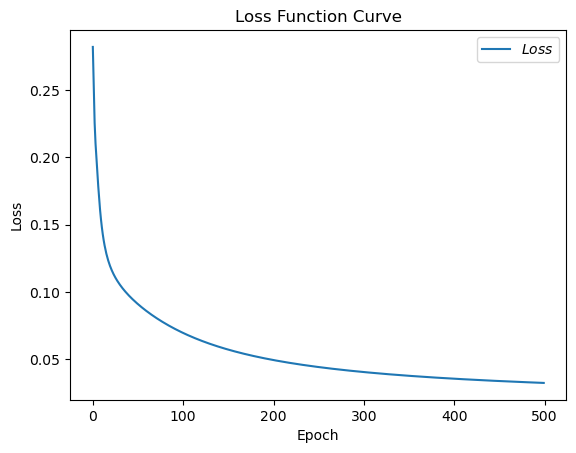

In [73]:
print(f'train_loss_results = {train_loss_results}')
# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

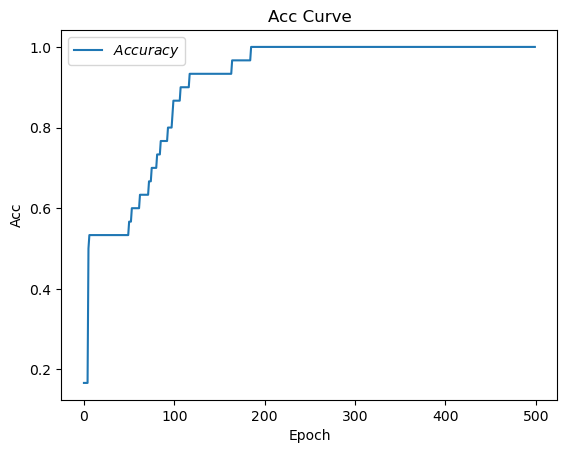

In [74]:
# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()